In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop,Adam
from keras.callbacks import History
from keras import callbacks

# mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Input files don't have column names
dependent_var = ['RUL']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

#import data

In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/data/NASA_Turbofan_Jet/train_FD001.txt",delim_whitespace=True,names=input_file_column_names)

In [5]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Culculate RUL (remaining useful life)

In [6]:
rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
df_train['RUL'] = df_train['max'] - df_train['Cycle']
df_train.drop('max', axis=1, inplace=True)

df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [7]:
rul.head()

,UnitNumber,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


In [8]:
df_test = pd.read_csv('/content/drive/MyDrive/data/NASA_Turbofan_Jet/test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [9]:
y_true = pd.read_csv('/content/drive/MyDrive/data/NASA_Turbofan_Jet/RUL_FD001.txt',delim_whitespace=True,names=["RUL"])
y_true["UnitNumber"] = y_true.index
y_true.head()

,RUL,UnitNumber
0,112,0
1,98,1
2,69,2
3,82,3
4,91,4


#Data exploration

In [10]:
df_train.shape

(20631, 27)

In [11]:
df_train.isnull().sum()

UnitNumber         0
Cycle              0
OpSet1             0
OpSet2             0
OpSet3             0
SensorMeasure1     0
SensorMeasure2     0
SensorMeasure3     0
SensorMeasure4     0
SensorMeasure5     0
SensorMeasure6     0
SensorMeasure7     0
SensorMeasure8     0
SensorMeasure9     0
SensorMeasure10    0
SensorMeasure11    0
SensorMeasure12    0
SensorMeasure13    0
SensorMeasure14    0
SensorMeasure15    0
SensorMeasure16    0
SensorMeasure17    0
SensorMeasure18    0
SensorMeasure19    0
SensorMeasure20    0
SensorMeasure21    0
RUL                0
dtype: int64

##Unit

In [12]:
df_train.UnitNumber.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

Dataframe contains 100 deferent units

##Cycle

Text(0.5, 1.0, 'Life of Engines')

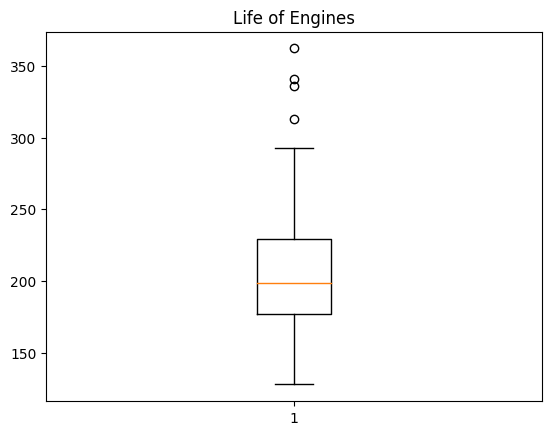

In [13]:
temp_df = df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max()
plt.boxplot(temp_df.Cycle)
plt.title("Life of Engines")

In [14]:
df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max().sort_values(by = ["Cycle"], ascending= False).head(5)


,Cycle
UnitNumber,
69,362
92,341
96,336
67,313
83,293


In [15]:
df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max().sort_values(by = ["Cycle"], ascending= False).tail(5)

,Cycle
UnitNumber,
24,147
57,137
70,137
91,135
39,128


#RUL

Text(0.5, 1.0, 'RUL')

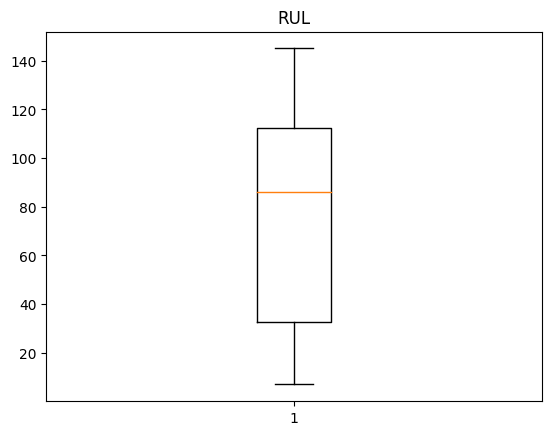

In [16]:
plt.boxplot(y_true.RUL)
plt.title("RUL")

##Operational setting

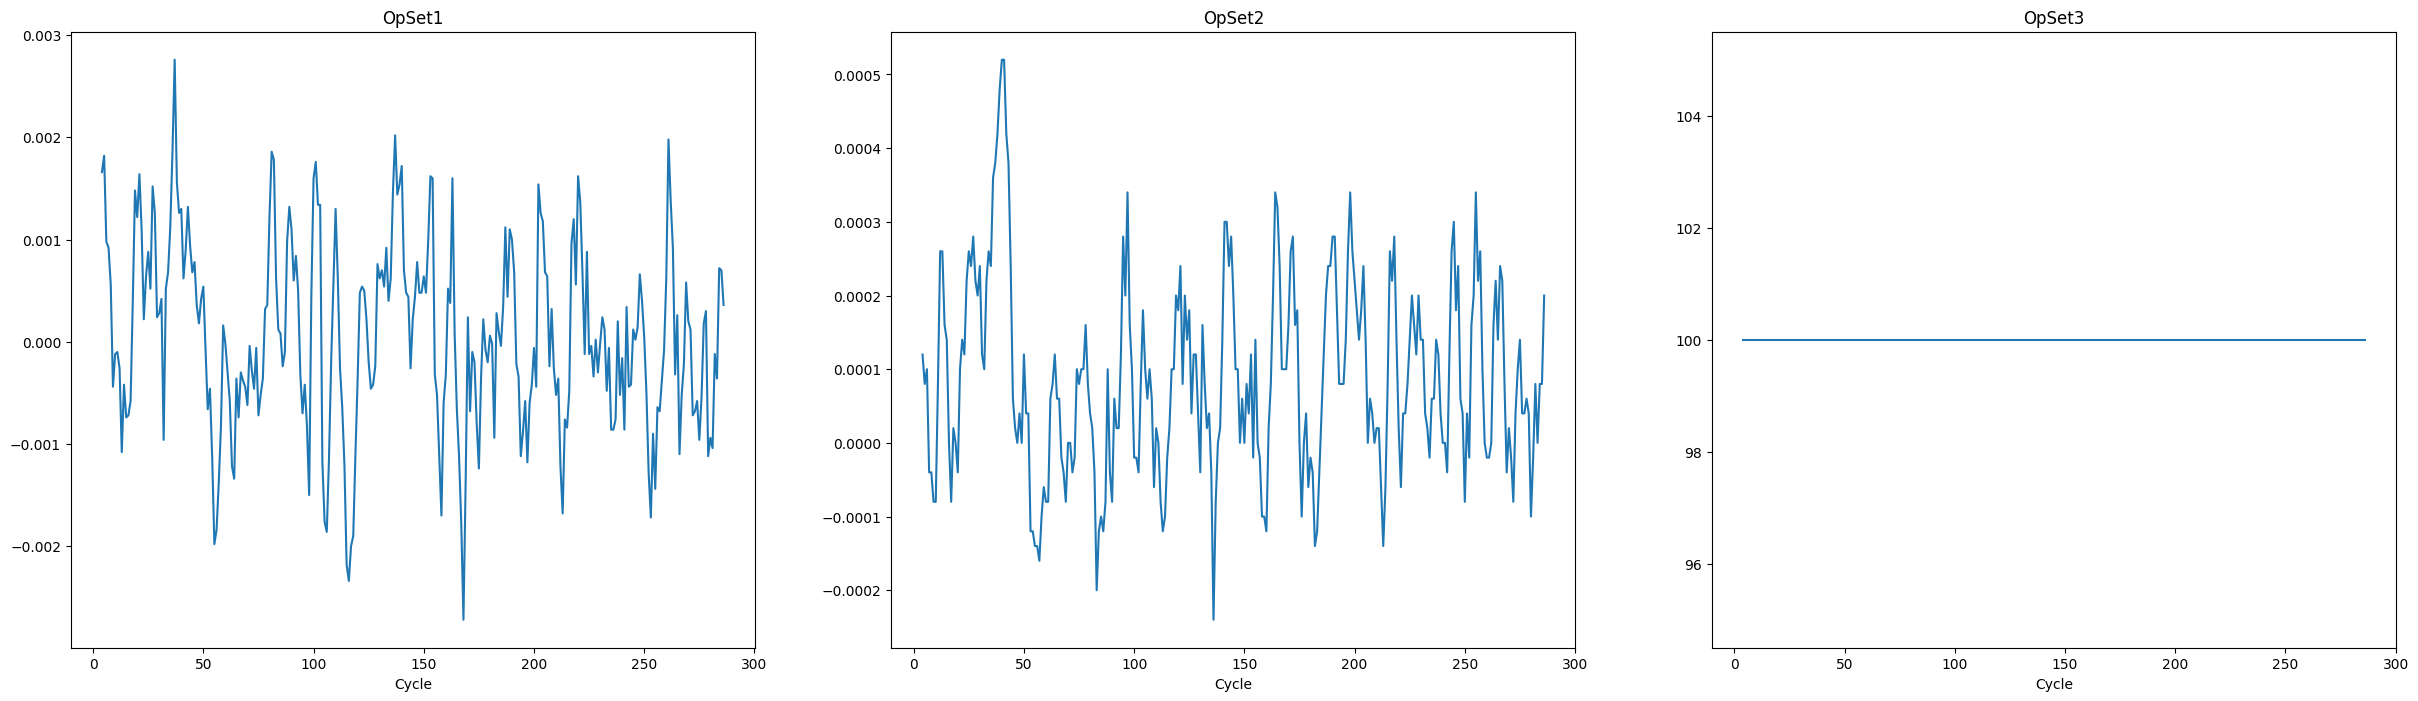

In [17]:
fig,ax=plt.subplots(1,3,figsize=(30,8),sharex='all')
for i in range(0,3):
    df_u1=df_train.query('UnitNumber==2').reset_index(drop = True)
    df_u1['rolling_avg'] = df_u1['OpSet'+str(i+1)].rolling(window = 5).mean()
    df_u1['rolling_avg'].plot(kind = "line", ax = ax[i])
    ax[i].set_title('OpSet'+str(i+1))
    ax[i].set_xlabel("Cycle")

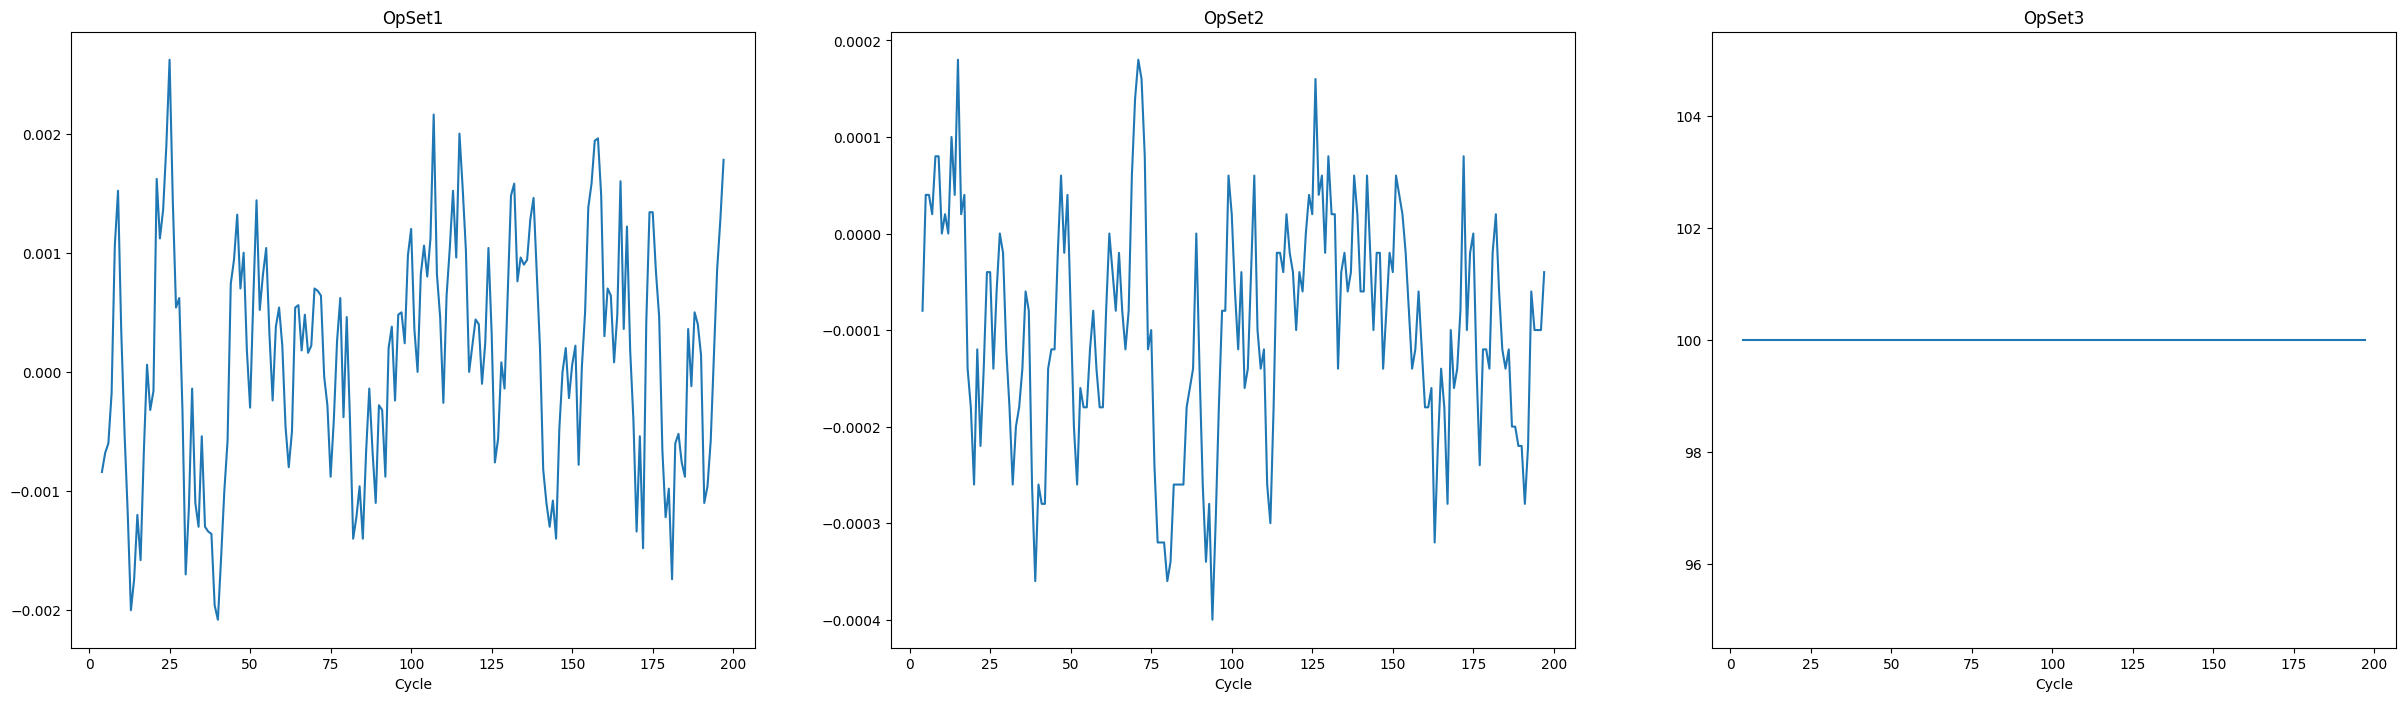

In [18]:
fig,ax=plt.subplots(1,3,figsize=(30,8),sharex='all')
for i in range(0,3):
    df_u1=df_train.query('UnitNumber==50').reset_index(drop = True)
    df_u1['rolling_avg'] = df_u1['OpSet'+str(i+1)].rolling(window = 5).mean()
    df_u1['rolling_avg'].plot(kind = "line", ax = ax[i])
    ax[i].set_title('OpSet'+str(i+1))
    ax[i].set_xlabel("Cycle")

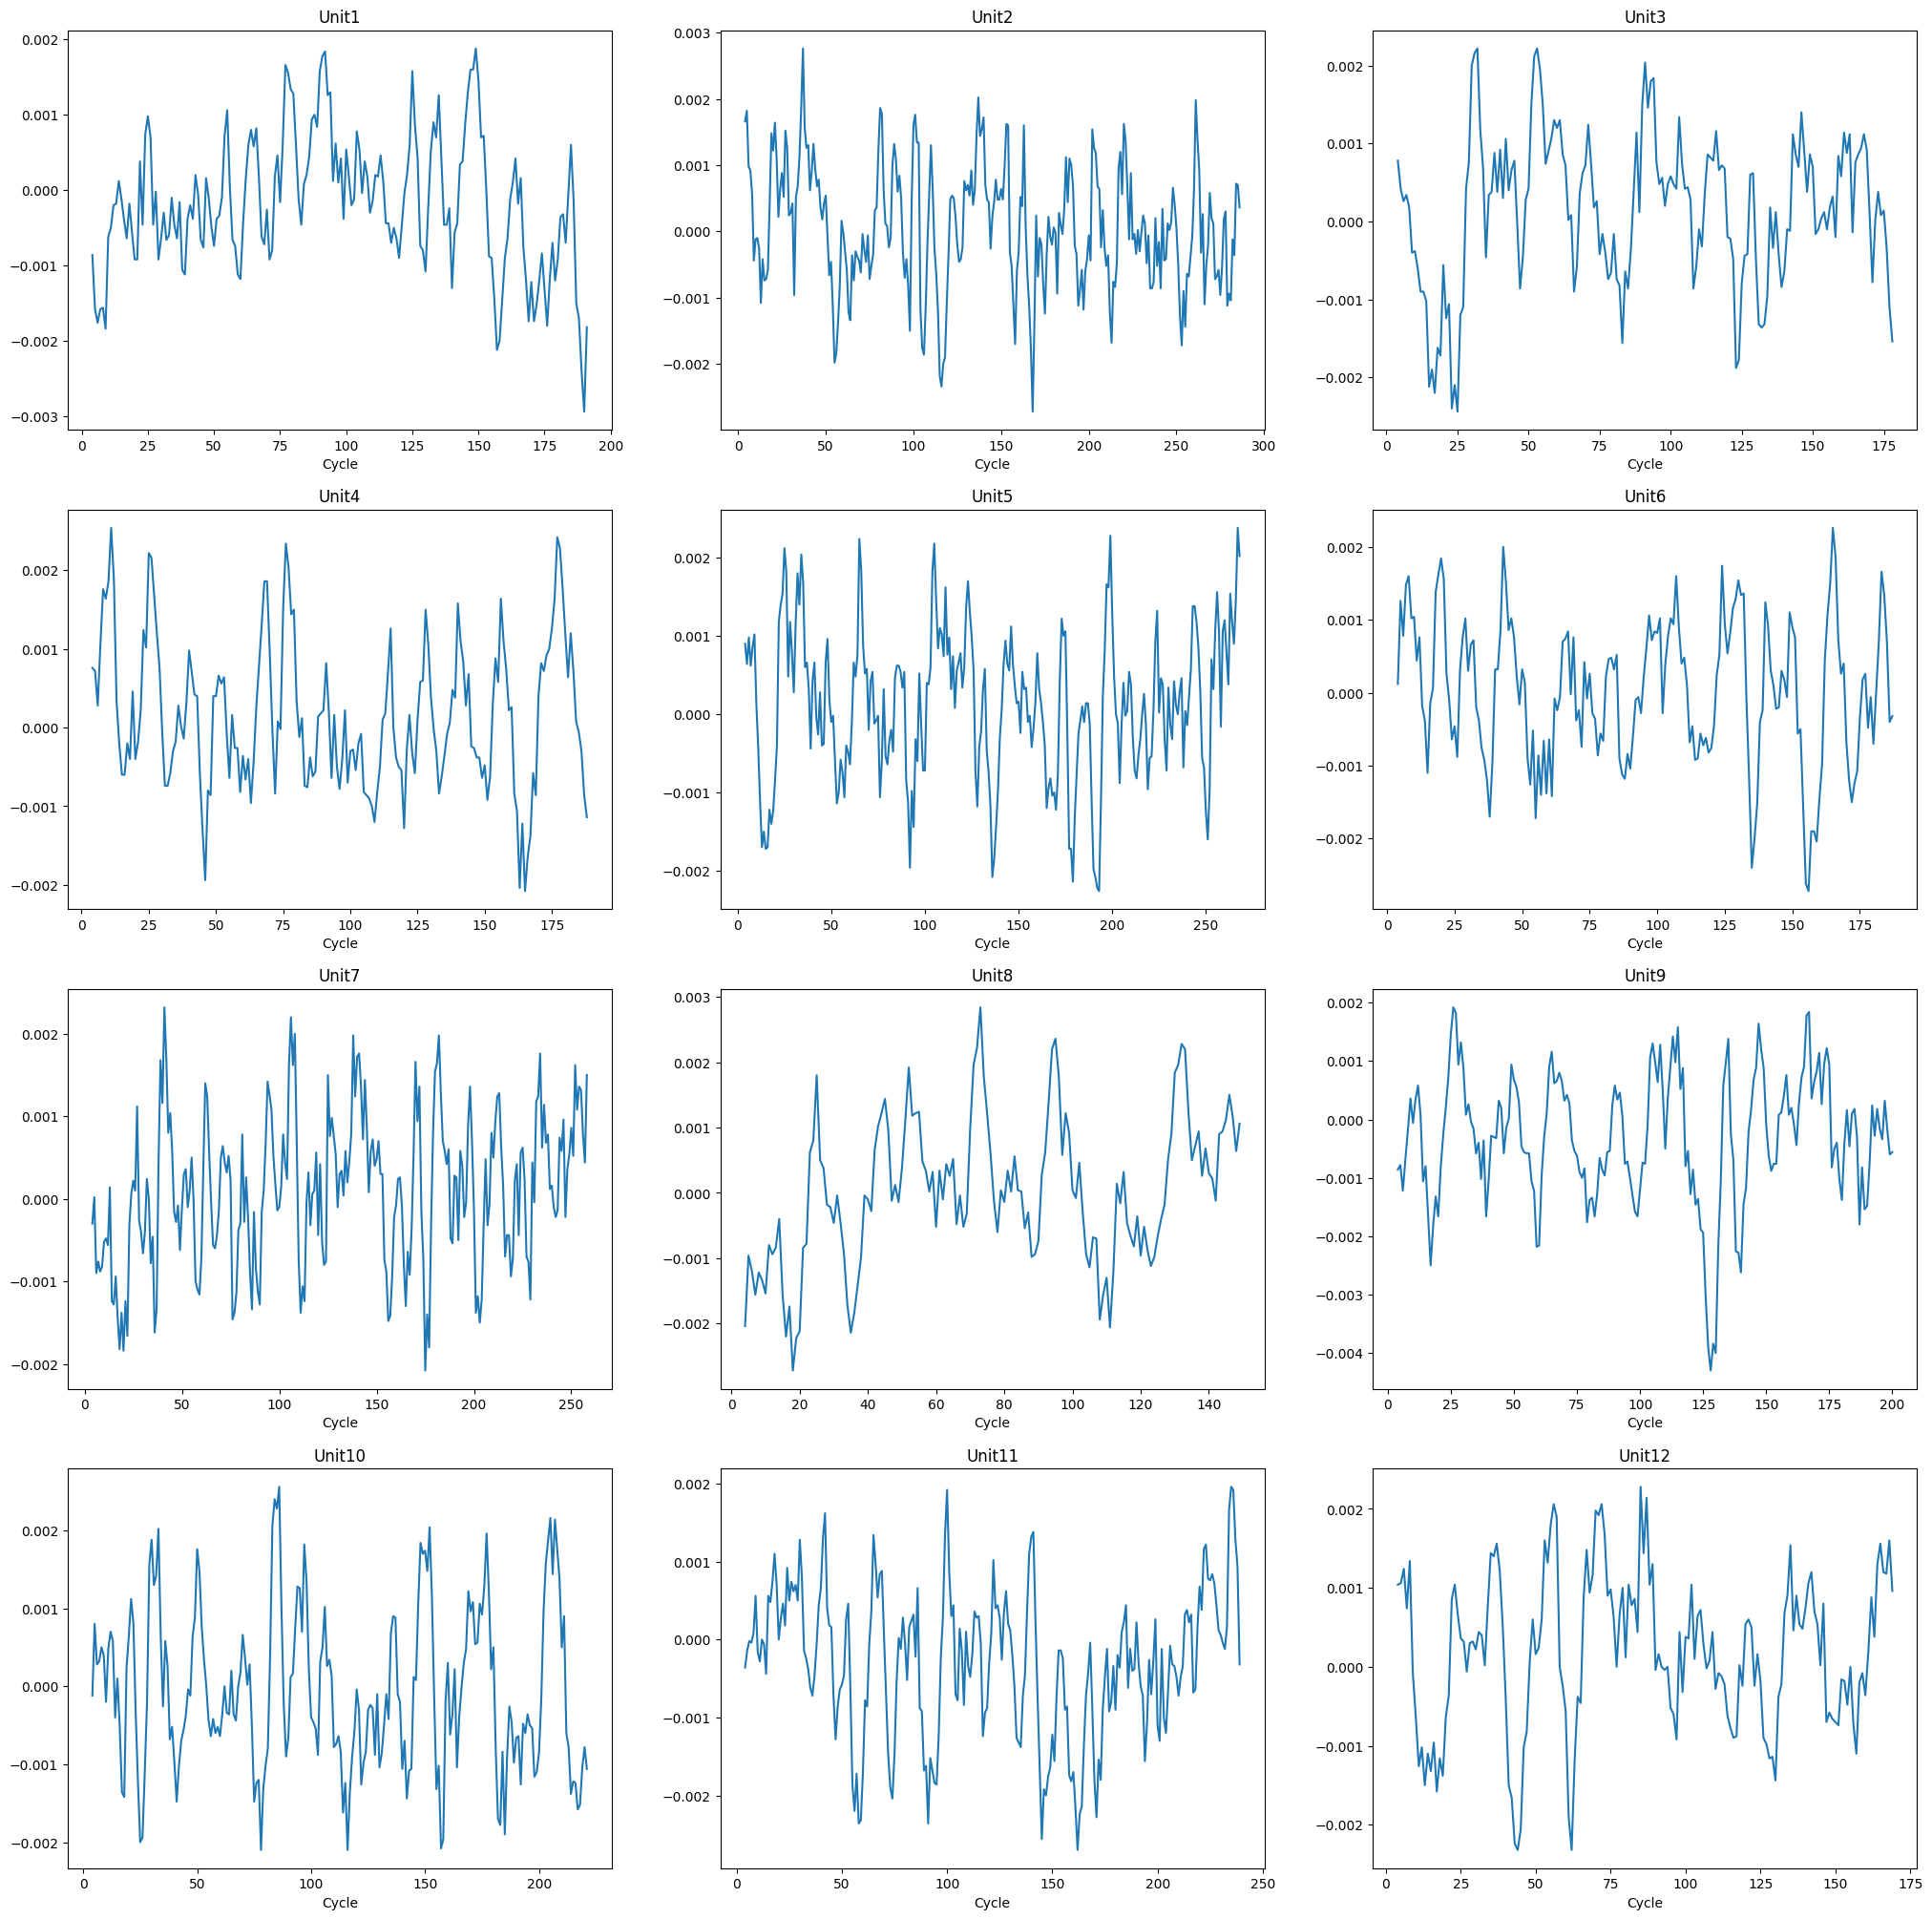

In [19]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (25,25))

ax = axes.ravel()

for i in range(0,12):
    temp = df_train.OpSet1[df_train.UnitNumber == i+1].reset_index(drop = True).rolling(window = 5).mean()
    temp.plot(kind = "line", ax = ax[i])
    ax[i].set_title('Unit'+str(i+1))
    ax[i].set_xlabel("Cycle")

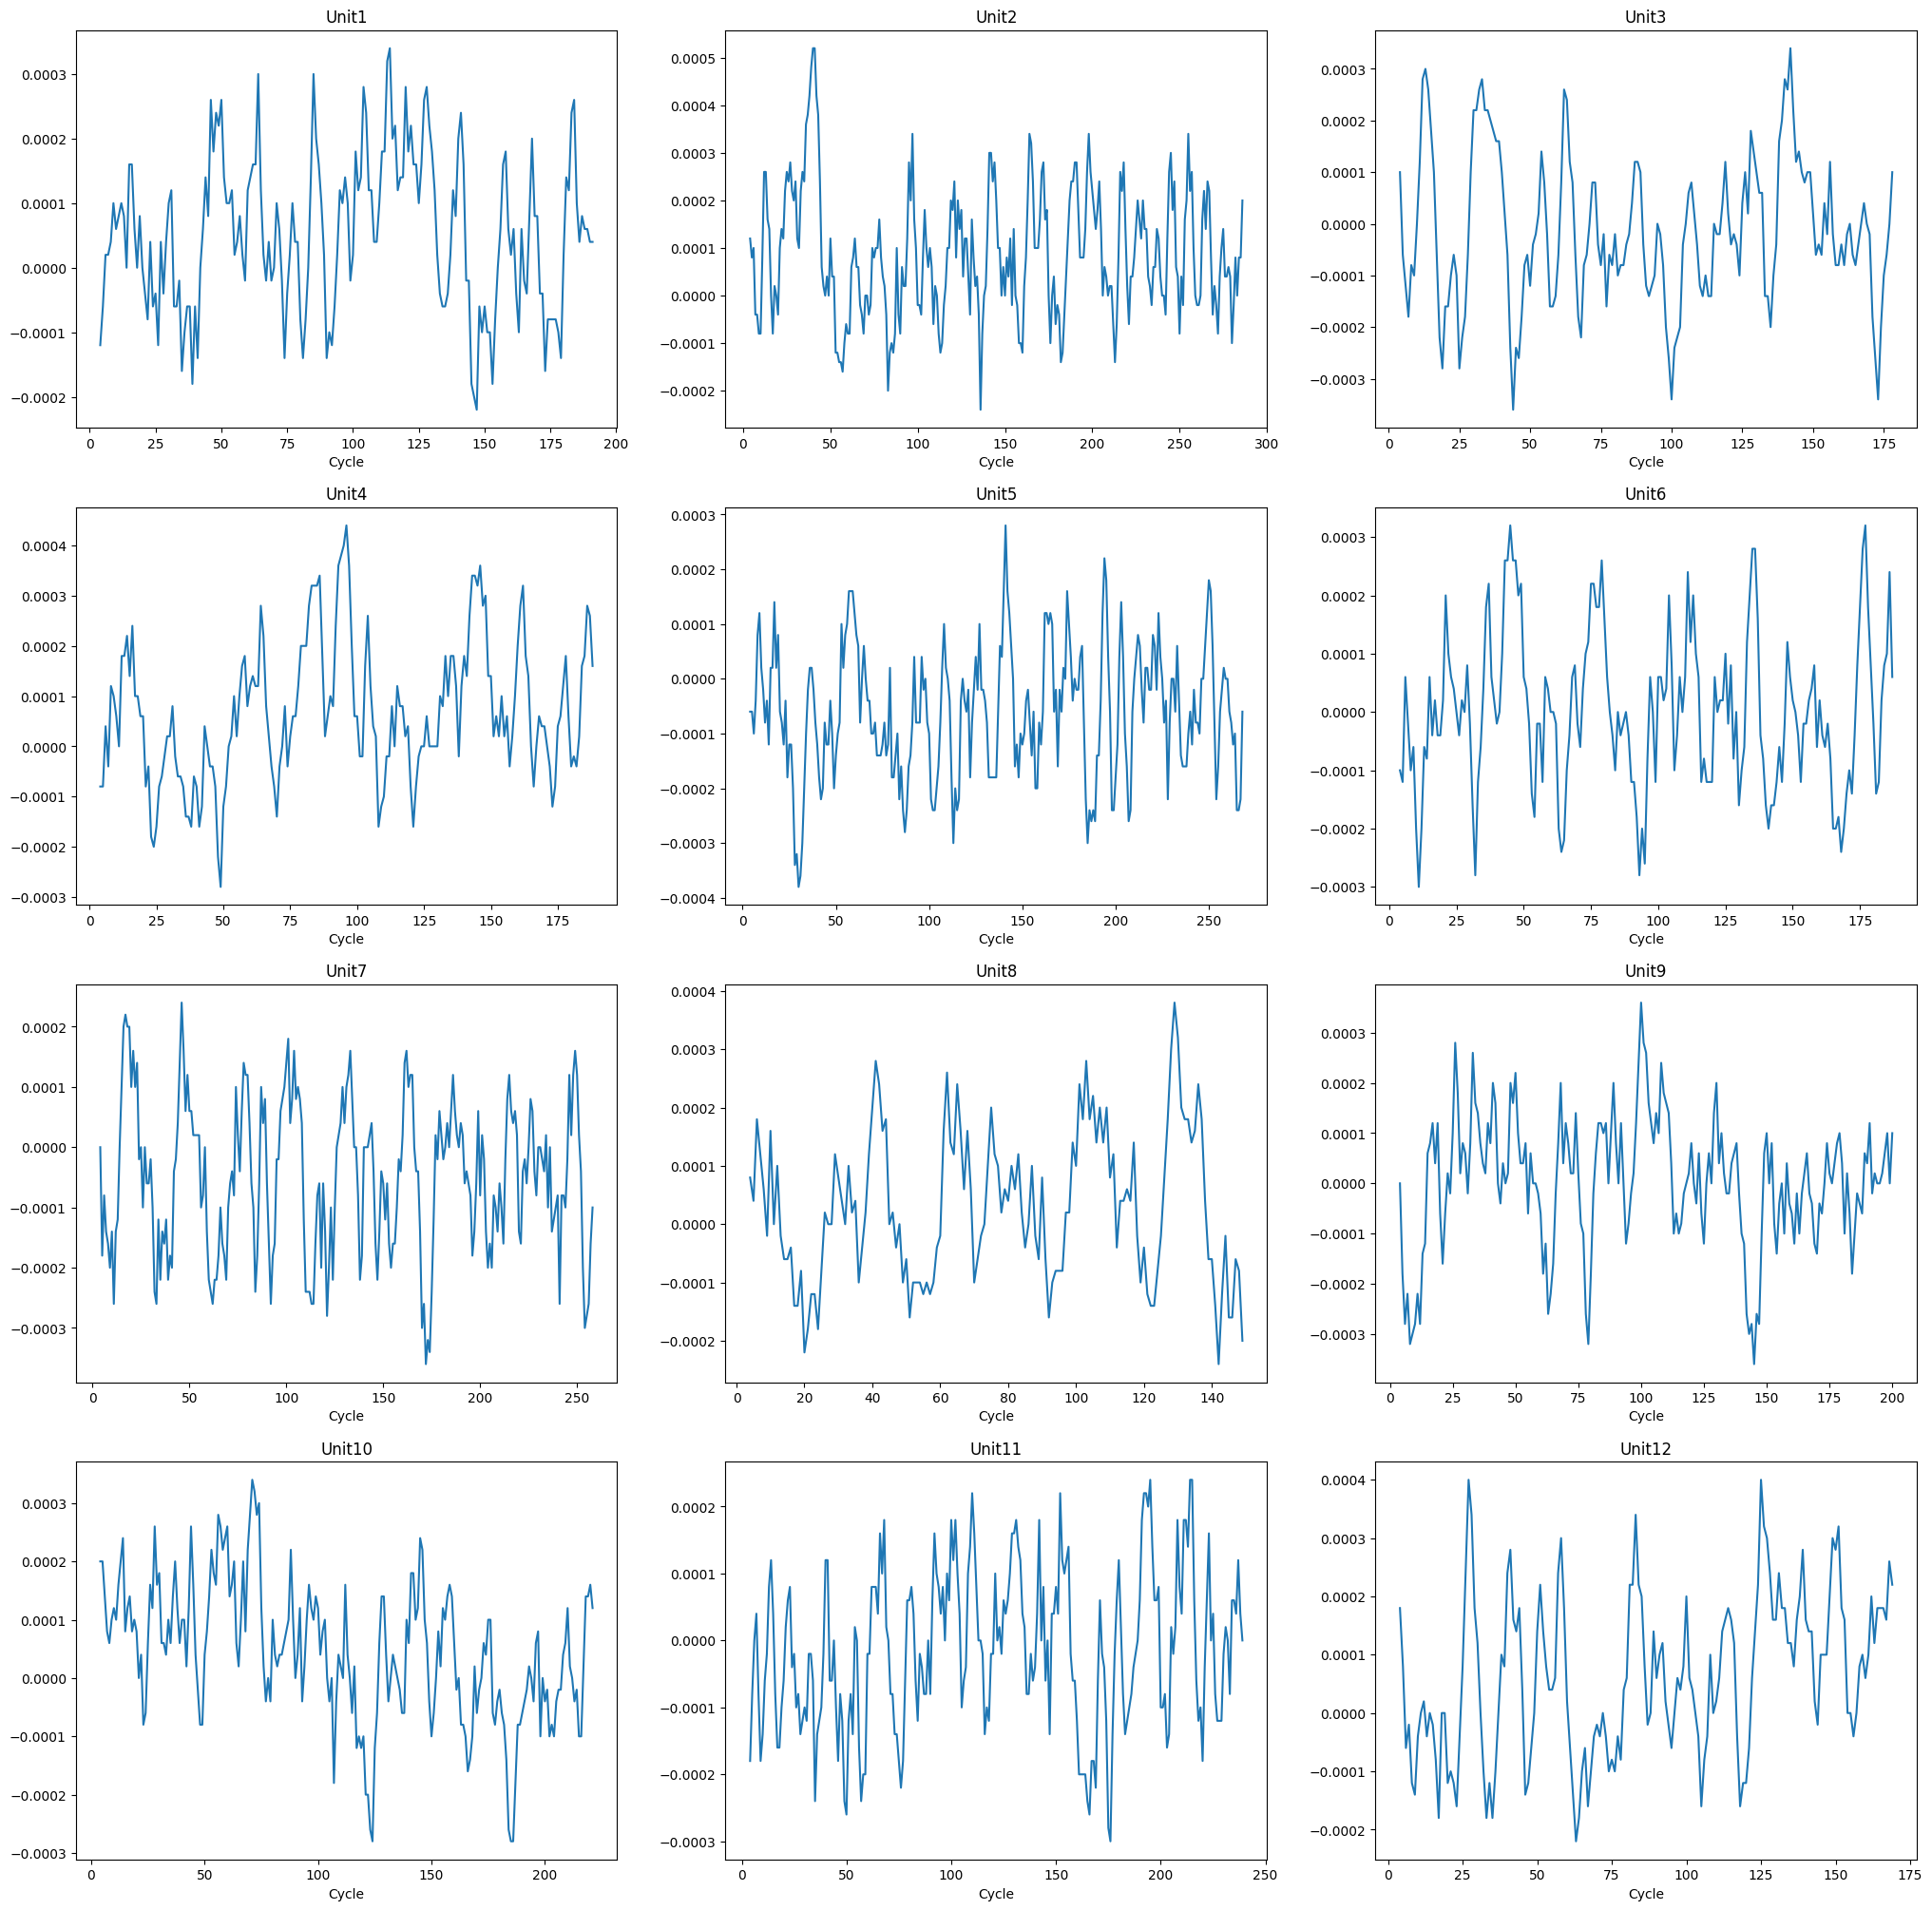

In [20]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (25,25))

ax = axes.ravel()

for i in range(0,12):
    temp = df_train.OpSet2[df_train.UnitNumber == i+1].reset_index(drop = True).rolling(window = 5).mean()
    temp.plot(kind = "line", ax = ax[i])
    ax[i].set_title('Unit'+str(i+1))
    ax[i].set_xlabel("Cycle")

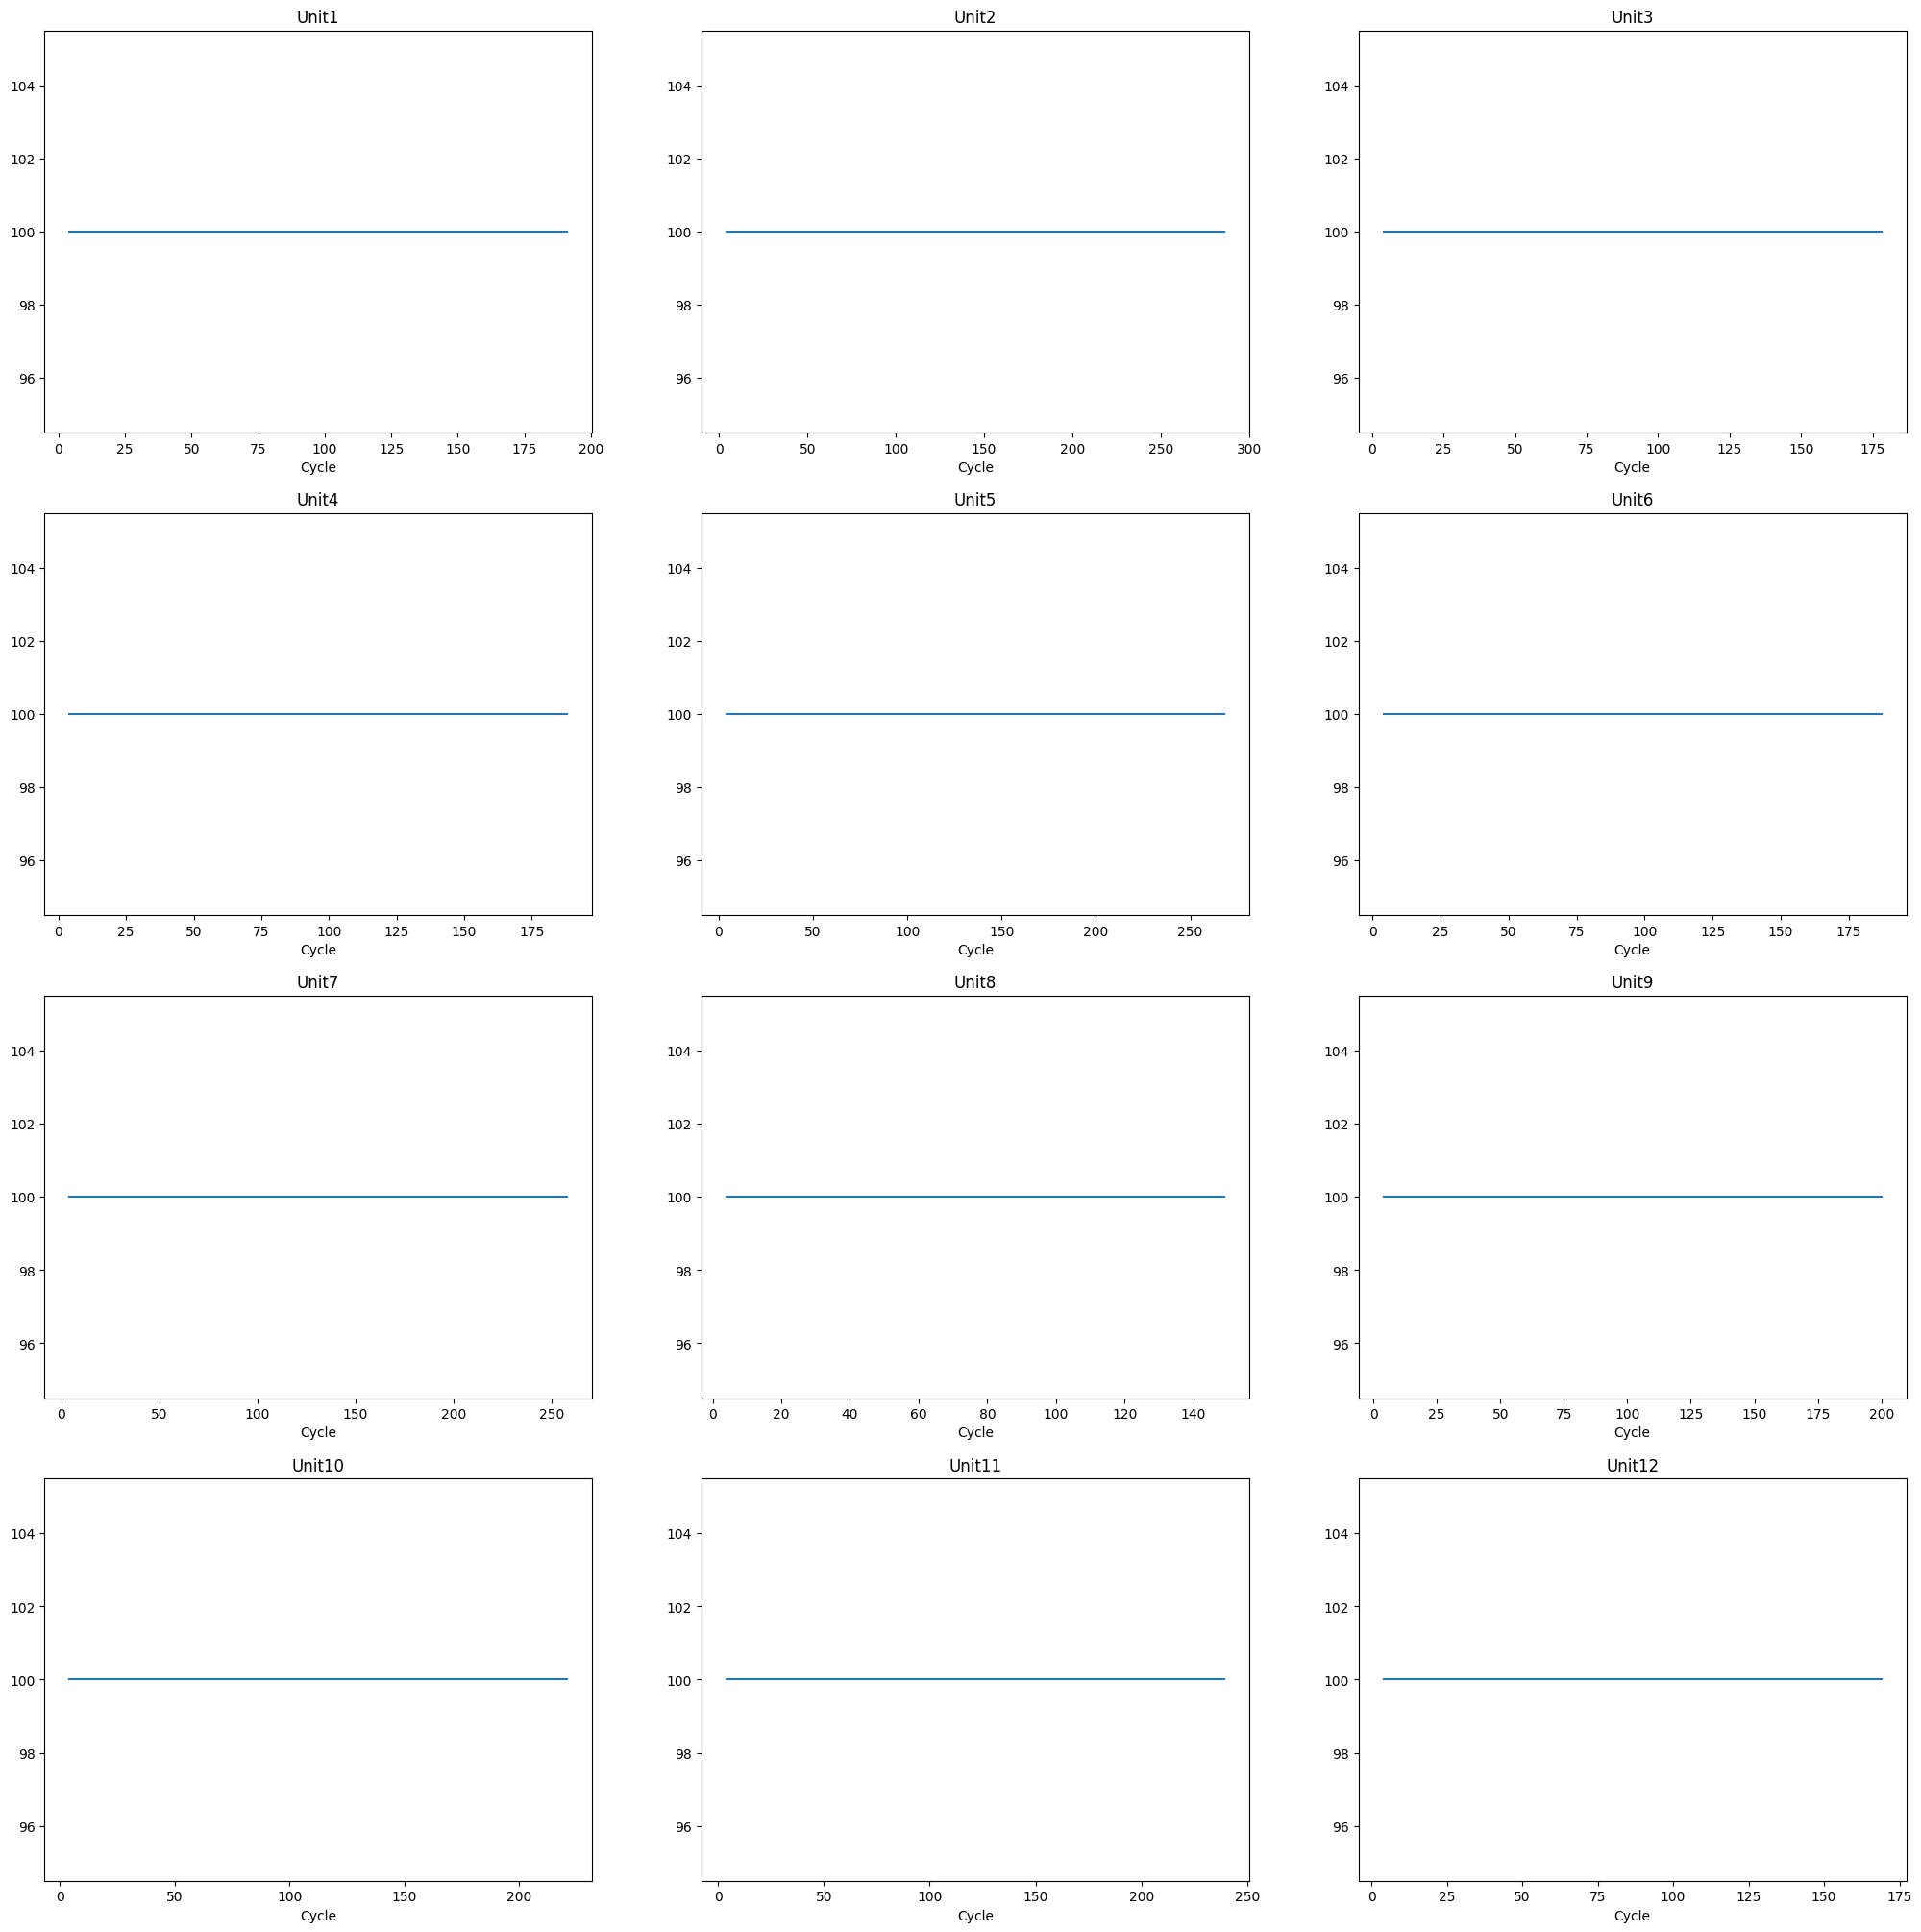

In [21]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (25,25))

ax = axes.ravel()

for i in range(0,12):
    temp = df_train.OpSet3[df_train.UnitNumber == i+1].reset_index(drop = True).rolling(window = 5).mean()
    temp.plot(kind = "line", ax = ax[i])
    ax[i].set_title('Unit'+str(i+1))
    ax[i].set_xlabel("Cycle")

In [22]:
temp_df = df_train.groupby('UnitNumber')['OpSet3'].std()
temp_df.sort_values(ascending=False).head()

UnitNumber
1     0.0
64    0.0
74    0.0
73    0.0
72    0.0
Name: OpSet3, dtype: float64

In [23]:
temp_df = df_train.groupby('UnitNumber')['OpSet3'].mean()
temp_df.sort_values(ascending=False).head()


UnitNumber
1     100.0
64    100.0
74    100.0
73    100.0
72    100.0
Name: OpSet3, dtype: float64

OpSet3 is constant and the value is same on all the units so the feature can be droped.

##Sensor Measurements

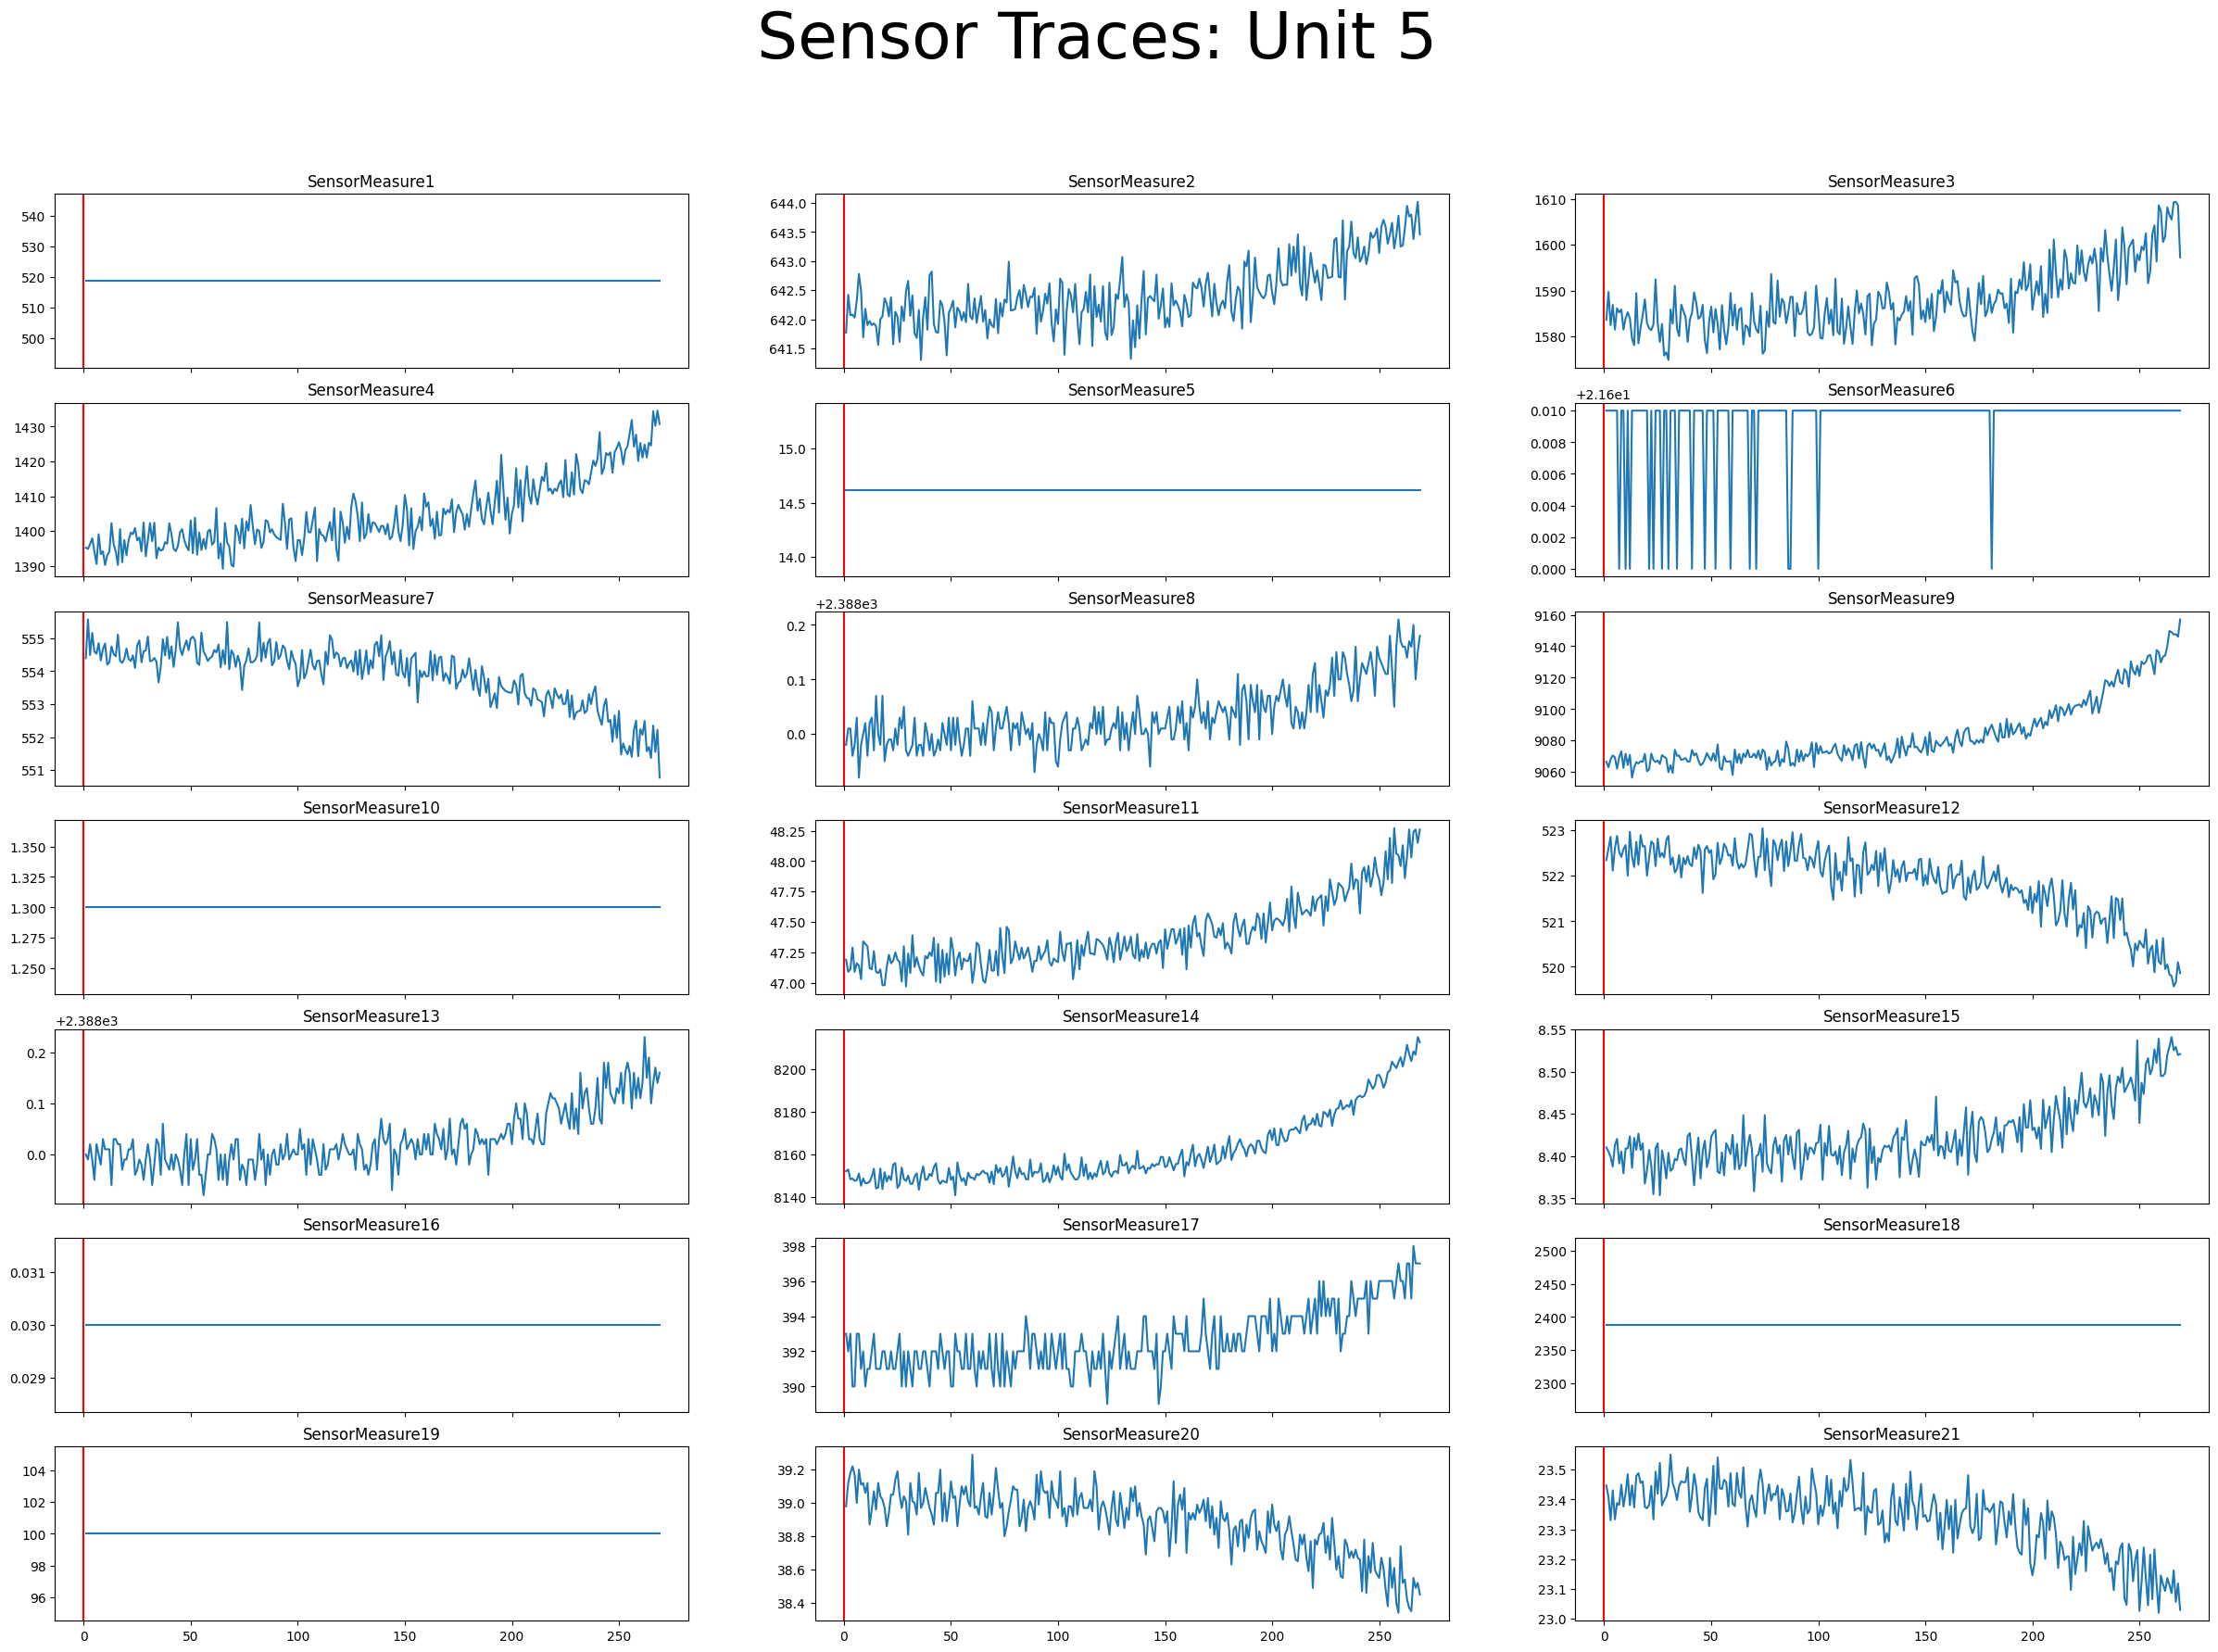

In [24]:
fig,ax=plt.subplots(7,3,figsize=(30,20),sharex=True)
df_u1=df_train.query('UnitNumber==5')
c=0
for i in range(0,7):
    for j in range(0,3):
        ax[i,j].plot(df_u1.Cycle.values, df_u1['SensorMeasure'+str(c+1)])
        ax[i,j].set_title('SensorMeasure'+str(c+1))
        ax[i,j].axvline(0,c='r')
        c+=1
plt.suptitle('Sensor Traces: Unit 5',fontsize=50)
plt.show()

Some sensors remain constant. Check their values across different engines.

In [25]:
temp_df = df_train.groupby('UnitNumber').std()
temp_df.head()

,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,...,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL
UnitNumber,,,,,,,,,,,,,,,,,,,,,
1,55.569776,0.001953,0.000282,0.0,0.0,0.486795,5.759776,8.565610,0.0,0.000000,...,0.076960,5.563129,0.034125,0.0,1.475661,0.0,0.0,0.166998,0.105101,55.569776
2,82.993976,0.002320,0.000298,0.0,0.0,0.560214,6.596730,9.737248,0.0,0.002491,...,0.063861,8.683012,0.041128,0.0,1.647280,0.0,0.0,0.199332,0.114796,82.993976
3,51.816986,0.002145,0.000290,0.0,0.0,0.474190,6.386222,8.610126,0.0,0.001482,...,0.041219,29.439715,0.036620,0.0,1.570773,0.0,0.0,0.166112,0.104734,51.816986
4,54.703748,0.002033,0.000286,0.0,0.0,0.441446,6.109152,7.737463,0.0,0.000727,...,0.034819,30.691780,0.031947,0.0,1.602848,0.0,0.0,0.159302,0.093804,54.703748
5,77.797815,0.002119,0.000279,0.0,0.0,0.551542,7.060648,9.782341,0.0,0.002503,...,0.056445,16.480153,0.038658,0.0,1.740057,0.0,0.0,0.187133,0.112705,77.797815


In [26]:
temp_df.sum(axis = 0) == 0

Cycle              False
OpSet1             False
OpSet2             False
OpSet3              True
SensorMeasure1      True
SensorMeasure2     False
SensorMeasure3     False
SensorMeasure4     False
SensorMeasure5      True
SensorMeasure6     False
SensorMeasure7     False
SensorMeasure8     False
SensorMeasure9     False
SensorMeasure10     True
SensorMeasure11    False
SensorMeasure12    False
SensorMeasure13    False
SensorMeasure14    False
SensorMeasure15    False
SensorMeasure16     True
SensorMeasure17    False
SensorMeasure18     True
SensorMeasure19     True
SensorMeasure20    False
SensorMeasure21    False
RUL                False
dtype: bool

###Sensor1

In [27]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure1'].mean()
temp_df.head()

UnitNumber
1    518.67
2    518.67
3    518.67
4    518.67
5    518.67
Name: SensorMeasure1, dtype: float64

In [28]:
temp_df.std()

0.0

In [29]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure5'].mean()
temp_df.head()

UnitNumber
1    14.62
2    14.62
3    14.62
4    14.62
5    14.62
Name: SensorMeasure5, dtype: float64

In [30]:
temp_df.min(), temp_df.max()

(14.619999999999997, 14.620000000000001)

In [31]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure10'].mean()
temp_df.head()

UnitNumber
1    1.3
2    1.3
3    1.3
4    1.3
5    1.3
Name: SensorMeasure10, dtype: float64

In [32]:
temp_df.min(), temp_df.max()

(1.3, 1.3000000000000003)

In [33]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure16'].mean()
temp_df.head()

UnitNumber
1    0.03
2    0.03
3    0.03
4    0.03
5    0.03
Name: SensorMeasure16, dtype: float64

In [34]:
temp_df.min(), temp_df.max()

(0.029999999999999995, 0.030000000000000002)

In [35]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure18'].mean()
temp_df.head()

UnitNumber
1    2388.0
2    2388.0
3    2388.0
4    2388.0
5    2388.0
Name: SensorMeasure18, dtype: float64

In [36]:
temp_df.min(), temp_df.max()

(2388.0, 2388.0)

In [37]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure19'].mean()
temp_df.head()

UnitNumber
1    100.0
2    100.0
3    100.0
4    100.0
5    100.0
Name: SensorMeasure19, dtype: float64

In [38]:
temp_df.min(), temp_df.max()

(100.0, 100.0)

 SensorMeasure1, SensorMeasure5, SensorMeasure10, SensorMeasure16, SensorMeasure18, and SensorMeasure19 remain almost constant so can be removed for dimension reduction.


In [39]:
# necessary features for analysis
not_required_feats = ["SensorMeasure1", "SensorMeasure5", "SensorMeasure10",
                      "SensorMeasure16", "SensorMeasure18", "SensorMeasure19"]
feats = [feat for feat in sensor_measure_columns_names if feat not in not_required_feats]
feats

['SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure6',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure14',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

# Correlation map

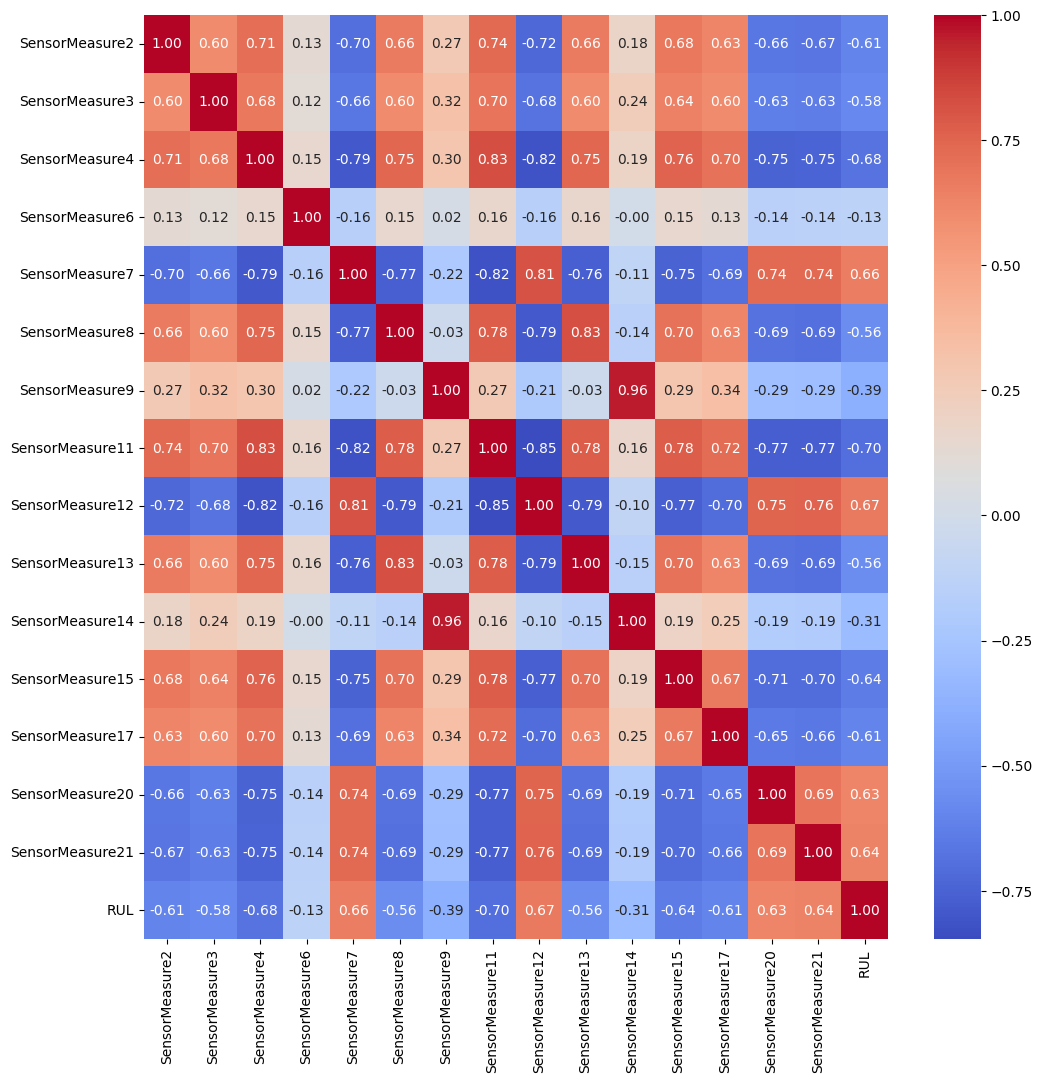

In [40]:
corr = df_train[feats + ["RUL"]].corr()

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax = sns.heatmap(corr, annot=True, cmap = "coolwarm", fmt=".2f")

Sensor 9 and Sensor 14 have high correlationship.

<Axes: xlabel='SensorMeasure14', ylabel='SensorMeasure9'>

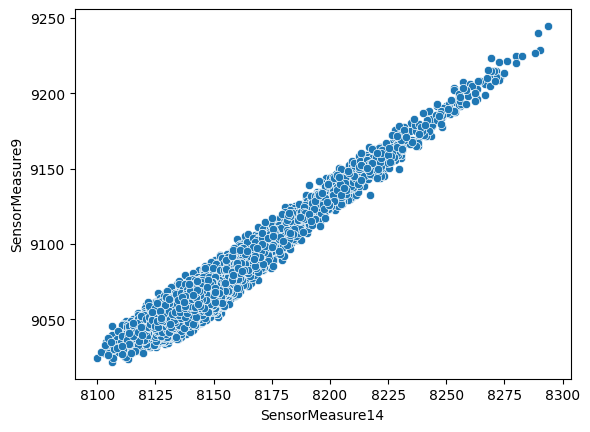

In [41]:
sns.scatterplot(x = df_train.SensorMeasure14, y = df_train.SensorMeasure9)

In [42]:
feats = [i for i in feats if "SensorMeasure14" not in i]
feats

['SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure6',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

# preprocess function

In [43]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index

    return df_train, df_test, y_true

In [44]:
import os
os.chdir("/content/drive/MyDrive/data/NASA_Turbofan_Jet")

In [45]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

((20631, 19), (13096, 18), (100, 2))

In [46]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.fit_transform(df_test[feats])

In [47]:
df_train[feats]

,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,-0.632530,-0.186396,-0.380486,1.0,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-5.882353e-01,-0.272028,-0.333333,0.426357,0.449323
1,-0.433735,-0.093961,-0.294733,1.0,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-4.411765e-01,-0.177376,-0.333333,0.333333,0.462027
2,-0.313253,-0.260955,-0.258947,1.0,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-5.588235e-01,-0.285110,-0.666667,0.255814,0.242751
3,-0.313253,-0.487683,-0.337610,1.0,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-4.117647e-01,-0.666795,-0.333333,0.147287,0.324772
4,-0.301205,-0.485066,-0.190749,1.0,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-5.294118e-01,-0.195845,-0.166667,0.178295,0.409003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.373494,0.174624,0.565834,1.0,-0.491143,-0.121212,-0.607018,0.452381,-0.658849,1.176471e-01,0.313582,0.500000,-0.457364,-0.781000
20627,0.403614,0.458906,0.732951,1.0,-0.674718,0.000000,-0.610697,0.416667,-0.577825,-9.094947e-13,0.454406,0.166667,-0.751938,-0.267606
20628,0.331325,0.369959,0.550641,1.0,-0.648953,0.030303,-0.603608,0.476190,-0.437100,5.882353e-02,0.844556,0.666667,-0.534884,-0.892019
20629,0.216867,0.492043,0.494936,1.0,-0.732689,0.060606,-0.533429,0.833333,-0.582090,2.941176e-02,0.646787,0.166667,-0.767442,-0.531069


LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [48]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

In [49]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [50]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value

    id_df = df_mask.append(id_df,ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    start = num_elements-seq_length
    stop = num_elements

    lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)


In [51]:
sequence_length = 50
mask_value = 0

In [52]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 14)


In [53]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [54]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
x_test.shape

<ipython-input-50-67bfa53ae23e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)
<ipython-input-50-67bfa53ae23e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)
<ipython-input-50-67bfa53ae23e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)
<ipython-input-50-67bfa53ae23e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)
<ipython-input-50-67bfa53ae23e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

(100, 50, 14)

In [55]:
#true target of test
y_test = y_true.RUL.values
y_test.shape

(100,)

#LSTM

In [56]:
nb_features = x_train.shape[2]
nb_out = 1

In [57]:
nb_features

14

#Model

In [58]:
history = History()

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="adam", metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           46000     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 126501 (494.14 KB)
Trainable params: 12650

In [59]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1,
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
394/394 [==============================] - 45s 94ms/step - loss: 5752.5889 - mse: 5752.5889 - val_loss: 7108.5190 - val_mse: 7108.5190
Epoch 2/100
394/394 [==============================] - 38s 96ms/step - loss: 3551.2798 - mse: 3551.2798 - val_loss: 5412.0898 - val_mse: 5412.0898
Epoch 3/100
394/394 [==============================] - 39s 99ms/step - loss: 3039.8684 - mse: 3039.8684 - val_loss: 4914.0732 - val_mse: 4914.0732
Epoch 4/100
394/394 [==============================] - 46s 116ms/step - loss: 2964.6877 - mse: 2964.6877 - val_loss: 4783.5396 - val_mse: 4783.5396
Epoch 5/100
394/394 [==============================] - 36s 92ms/step - loss: 2954.1885 - mse: 2954.1885 - val_loss: 4766.1641 - val_mse: 4766.1641
Epoch 6/100
394/394 [==============================] - 38s 96ms/step - loss: 2959.6792 - mse: 2959.6792 - val_loss: 4758.0747 - val_mse: 4758.0747
Epoch 7/100
394/394 [==============================] - 44s 112ms/step - loss: 2961.0305 - mse: 2961.0305 - val_loss: 

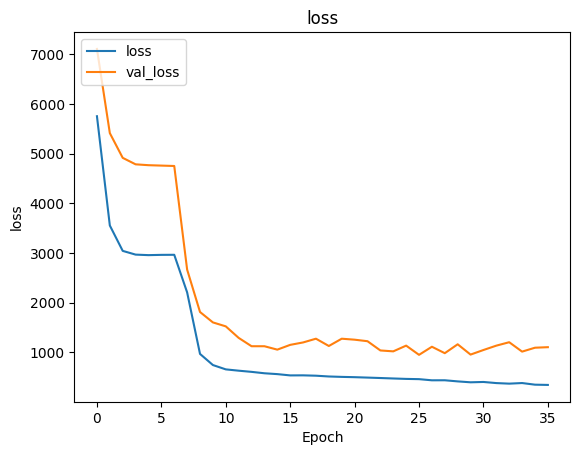

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [61]:
# scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
# print('MSE: {}'.format(scores[1]))

In [62]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print('MSE: {}'.format(scores_test[1]))

4/4 - 0s - loss: 1831.1000 - mse: 1831.1000 - 101ms/epoch - 25ms/step
MSE: 1831.0999755859375


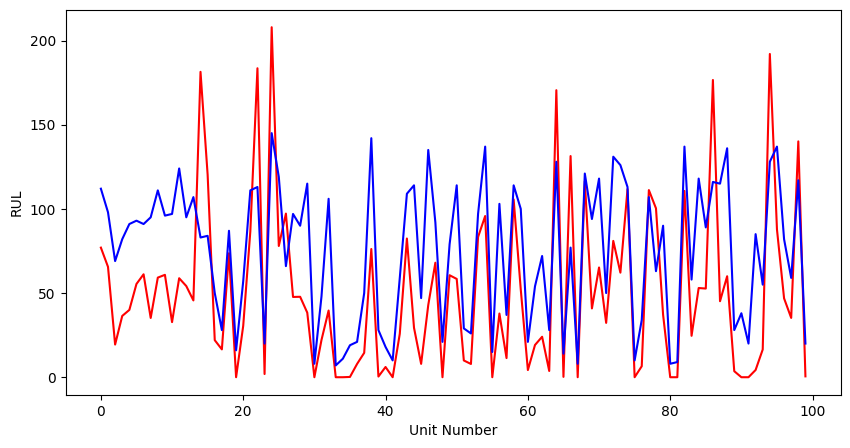

In [66]:
y_pred = model.predict(x_test, verbose=0)

plt.figure(figsize=(10,5))
plt.plot(y_pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
# plt.legend(loc='upper left')
plt.show()